### **Quick introduction to jupyter notebooks**
* Each cell in this notebook contains either code or text.
* You can run a cell by pressing Ctrl-Enter, or run and advance to the next cell with Shift-Enter.
* Code cells will print their output, including images, below the cell. Running it again deletes the previous output, so be careful if you want to save some results.
* You don't have to rerun all cells to test changes, just rerun the cell you have made changes to. Some exceptions might apply, for example if you overwrite variables from previous cells, but in general this will work.
* If all else fails, use the "Kernel" menu and select "Restart Kernel and Clear All Output". You can also use this menu to run all cells.
* A useful debug tool is the console. You can right-click anywhere in the notebook and select "New console for notebook". This opens a python console which shares the environment with the notebook, which let's you easily print variables or test commands.

### **Setup**

In [94]:
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2
# Plot figures "inline" with other output
%matplotlib inline

# Import modules, classes, functions
from matplotlib import pyplot as plt
import numpy as np

from utils import loadDataset, splitData, plotProgress, plotProgressNetworkMulti, \
    plotResultsDots, plotIsolines, plotConfusionMatrixOCR, plotResultsDotsGradient
from evalFunctions import calcAccuracy, calcConfusionMatrix

# Configure nice figures
plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(8, 5)

### ***! IMPORTANT NOTE !***

Your implementation should only use the `numpy` (`np`) module. The `numpy` module provides all the functionality you need for this assignment and makes it easier debuging your code. No other modules, e.g. `scikit-learn` or `scipy` among others, are allowed and solutions using modules other than `numpy` will be sent for re-submission. You can find everything you need about `numpy` in the official [documentation](https://numpy.org/doc/stable/).

### **1. Multi-layer neural network**

The implementation of the multi-layer network is a bit beyond the scope of this course, so we will provide it for you. Your task is instead to optimize the training and interpret tthe results.

Similar to the single-layer network, the multi-layer keep track of weight matrices `W1` and `W2`, and bias vectors `B1` and `B2`. The structure of the code is still the same, with a `forward`, `backward`, and `update` function.

#### **1.1 Implementing the forward pass**

This implementation will look similar to the single-layer code, but note that it also returns the intemediate variable `U`, which is the output of the hidden layer after passing throught the activation function. This will be used in the backward pass.

In [95]:
def forward(X, W1, B1, W2, B2, useTanhOutput=False):
    """Forward pass of two layer network

    Args:
        X (array): Input samples.
        W1 (array): First layer neural network weights.
        B1 (array): First layer neural network biases.
        W2 (array): Second layer neural network weights.
        B2 (array): Second layer neural network biases.

    Returns:
        Y (array): Output for each sample and class.
        L (array): Resulting label of each sample.
        U (array): Output of hidden layer.
    """

    # --------------------------------------------
    # === Your code here ========================= 
    # -------------------------------------------- 

    def activation_function(x):
        return np.tanh(x)

    mult1 = W1.T @ X.T
    U = activation_function((mult1 + B1.T).T)

    mult2 = W2.T @ U.T
    Y = (B2.T + mult2).T
    
    # ============================================
    
    # Calculate labels
    L = Y.argmax(axis=1)

    return Y, L, U

#### **1.2 Implementing the backward pass**

This backward pass implementation uses the so called delta notation. This is very useful when implementing the general case of an N-layer network, since it can easily be implemnted in an iterative manner in a loop going over each layer. We will not do that in this assignment, but it is good to know that this is essentially how the popular frameworks for deep learning functions.

In [96]:
def backward(W1, B1, W2, B2, X, U, Y, D, useTanhOutput=False):
    """Compute the gradients for network weights and biases

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        X (array): Training samples.
        U (array): Intermediate outputs of the hidden layer.
        Y (array): Predicted outputs.
        D (array): Target outputs.
        
        useTanhOutput (bool): (optional)
            True  - Network uses tanh activation on output layer
            False - Network uses linear (no) activation on output layer
        
    Returns:
        GradW1 (array): Gradients with respect to W1
        GradB1 (array): Gradients with respect to B1
        GradW2 (array): Gradients with respect to W2
        GradB2 (array): Gradients with respect to B2
    """
    
    N  = Y.shape[0]
    NC = Y.shape[1]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------


    # Gradient for the output layer
    E2 = D - Y
    GradW2 = U.T @ E2 / N
    GradB2 = 2 * np.sum(E2, axis=0) / N

    # Gradient for the hidden layer
    GradW1 = X.T @ ((E2 @ W2.T) * (1 - U**2)) / N
    GradB1 = 2 * np.sum((E2 @ W2.T) * (1 - U**2), axis=0) / N
    
    # ============================================
    
    return GradW1, GradB1, GradW2, GradB2

#### **1.3 Implementing the weight update**

For this update function we have implemented a more powerful algorithm called momentum gradient descent. This is part of an optional task at the end of the notebook, and you do not have to use it unless you want to.

In [97]:
def update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params):
    """Update weights and biases using computed gradients.

    Args:
        W1 (array): Current values of the layer 1 network weights.
        B1 (array): Current values of the layer 1 network biases.
        W2 (array): Current values of the layer 2 network weights.
        B2 (array): Current values of the layer 2 network biases.
        
        GradW1 (array): Gradients with respect to W1.
        GradB1 (array): Gradients with respect to B1.
        GradW2 (array): Gradients with respect to W2.
        GradB2 (array): Gradients with respect to B2.
        
        params (dict):
            - learningRate: Scale factor for update step.
            - momentum: Scale factor for momentum update (optional).
        
    Returns:
        W1 (array): Updated layer 1 weights.
        B1 (array): Updated layer 1 biases.
        W2 (array): Updated layer 2 weights.
        B2 (array): Updated layer 2 biases.
    """
    
    LR = params["learningRate"]
    
    # Uncomment this is you are working on the optional task on momentum.
    # M = params["momentum"]
    # PrevGradW1 = params["PrevGradW1"]
    # PrevGradB1 = params["PrevGradB1"]
    # PrevGradW2 = params["PrevGradW2"]
    # PrevGradB2 = params["PrevGradB2"]
    
    # --------------------------------------------
    # === Your code here =========================
    # --------------------------------------------
    
    # Update weights
    W1 = W1 + LR * GradW1
    B1 = B1 + LR * GradB1
    W2 = W2 + LR * GradW2
    B2 = B2 + LR * GradB2
    
    # Uncomment this is you are working on the optional task on momentum.
    # params["PrevGradW1"] = ???
    # params["PrevGradB1"] = ???
    # params["PrevGradW2"] = ???
    # params["PrevGradB2"] = ???
    
    # ============================================
    
    return W1, B1, W2, B2
    

#### **1.4 The training function**

In [98]:
def trainMultiLayer(XTrain, DTrain, XTest, DTest, W1_0, B1_0, W2_0, B2_0, params):
    """Trains a two-layer network

    Args:
        XTrain (array): Training samples.
        DTrain (array): Training network target values.
        XTest (array): Test samples.
        DTest (array): Test network target values.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            epochs (int): Number of training steps.
            learningRate (float): Size of a training step.

    Returns:
        W1 (array): First layer weights after training.
        B1 (array): Fisrt layer biases after training.
        W2 (array): Second layer weights after training.
        B2 (array): Second layer biases after training.
        metrics (dict): Losses and accuracies for training and test data.
    """

    # Initialize variables
    metrics = {keys:np.zeros(params["epochs"]+1) for keys in ["lossTrain", "lossTest", "accTrain", "accTest"]}

    if "useTanhOutput" not in params:
        params["useTanhOutput"] = False
        
    if "momentum" not in params:
        params["momentum"] = 0       
    
    nTrain = XTrain.shape[0]
    nTest  = XTest.shape[0]
    nClasses = DTrain.shape[1]
    
    # Set initial weights
    W1 = W1_0
    B1 = B1_0
    W2 = W2_0
    B2 = B2_0
    
    # For optional task on momentum
    params["PrevGradW1"] = np.zeros_like(W1)
    params["PrevGradB1"] = np.zeros_like(B1)
    params["PrevGradW2"] = np.zeros_like(W2)
    params["PrevGradB2"] = np.zeros_like(B2)

    # Get class labels
    LTrain = np.argmax(DTrain, axis=1)
    LTest  = np.argmax(DTest , axis=1)

    # Calculate initial metrics
    YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
    YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
    
    # Including the initial metrics makes the progress plots worse, set nan to exclude
    metrics["lossTrain"][0] = np.nan # ((YTrain - DTrain)**2).mean()
    metrics["lossTest"][0]  = np.nan # ((YTest  - DTest )**2).mean()
    metrics["accTrain"][0]  = np.nan # (LTrainPred == LTrain).mean()
    metrics["accTest"][0]   = np.nan # (LTestPred  == LTest ).mean()

    # Create figure for plotting progress
    fig = plt.figure(figsize=(20,8), tight_layout=True)

    # Training loop
    for n in range(1, params["epochs"]+1):
        
        # --------------------------------------------
        # === This is the important part =============
        # === where your code is applied =============
        # --------------------------------------------
        
        # Compute gradients...
        GradW1, GradB1, GradW2, GradB2 = backward(W1, B1, W2, B2, XTrain, UTrain, YTrain, DTrain, params["useTanhOutput"])
        # ... and update weights
        W1, B1, W2, B2 = update(W1, B1, W2, B2, GradW1, GradB1, GradW2, GradB2, params)
        
        # ============================================
        
        # Evaluate errors
        YTrain, LTrainPred, UTrain = forward(XTrain, W1, B1, W2, B2, params["useTanhOutput"])
        YTest , LTestPred , _      = forward(XTest , W1, B1, W2, B2, params["useTanhOutput"])
        metrics["lossTrain"][n] = ((YTrain - DTrain)**2).mean()
        metrics["lossTest"][n]  = ((YTest  - DTest )**2).mean()
        metrics["accTrain"][n]  = (LTrainPred == LTrain).mean()
        metrics["accTest"][n]   = (LTestPred  == LTest ).mean()

        # Plot progress
        if (plotProgress and not n % 500) or n == params["epochs"]:
            if W1.shape[0] == 2 and W1.shape[1] <= 8:
                plotProgressNetworkMulti(fig, W1, B1, W2, B2, metrics, n=n)
            else:
                plotProgress(fig, metrics, n)

    return W1, B1, W2, B2, metrics

We also define the same function for normalizing the data, which is even more important now that we have more than one layer.

In [99]:
def normalize(X):
    # Compute mean and std
    m = X.mean(axis=0)
    s = X.std(axis=0)
    # Prevent division by 0 is feature has no variance
    s[s == 0] = 1
    # Return normalized data
    return (X - m) / s

#### **<span style="color:red">Question 1:</span>**

Explain why large, non-normalized input features might be a problem when using two layers, but not when using a single layer.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

---
### **2 Optimizing each dataset**

Like before, we define a function that performs the boilerplate code for training the networks.

In [100]:
def  trainMultiLayerOnDataset(datasetNr, testSplit, W1_0, B1_0, W2_0, B2_0, params):
    """Train a two layer network on a specific dataset.

    Ags:
        datasetNr (int): ID of dataset to use
        testSplit (float): Fraction of data reserved for testing.
        W1_0 (array): Initial values of the first layer network weights.
        B1_0 (array): Initial values of the first layer network biases.
        W2_0 (array): Initial values of the second layer network weights.
        B2_0 (array): Initial values of the second layer network biases.
        params (dict): Dictionary containing:
            nIterations (int): Number of training steps.
            learningRate (float): Size of a training step.
    """
    
    # Load data and split into training and test sets
    X, D, L = loadDataset(datasetNr)
    XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, testSplit)
    
    if "normalize" in params and params["normalize"]:
        XTrainNorm = normalize(XTrain)
        XTestNorm  = normalize(XTest)
    else:
        XTrainNorm = XTrain
        XTestNorm  = XTest

    # Train network
    W1, B1, W2, B2, metrics = trainMultiLayer(XTrainNorm, DTrain, XTestNorm, DTest, W1_0, B1_0, W2_0, B2_0, params)

    # Predict classes on test set
    LPredTrain = forward(XTrainNorm, W1, B1, W2, B2, params["useTanhOutput"])[1]
    LPredTest  = forward(XTestNorm , W1, B1, W2, B2, params["useTanhOutput"])[1]

    # Compute metrics
    accTrain = calcAccuracy(LPredTrain, LTrain)
    accTest  = calcAccuracy(LPredTest , LTest)
    confMatrix = calcConfusionMatrix(LPredTest, LTest)

    # Display results
    print(f'Train accuracy: {accTrain:.4f}')
    print(f'Test accuracy: {accTest:.4f}')
    print("Test data confusion matrix:")
    print(confMatrix)

    if datasetNr < 4:
        # Switch between these two functions to see another way to visualize the network output.
        plotResultsDots(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[1])
        #plotResultsDotsGradient(XTrainNorm, LTrain, LPredTrain, XTestNorm, LTest, LPredTest, lambda X: forward(X, W1, B1, W2, B2, params["useTanhOutput"])[0])
    else:
        plotConfusionMatrixOCR(XTest, LTest, LPredTest)

#### **2.1 Optimizing dataset 1**

Train accuracy: 0.9900
Test accuracy: 0.9967
Test data confusion matrix:
[[163.   0.]
 [  1. 136.]]


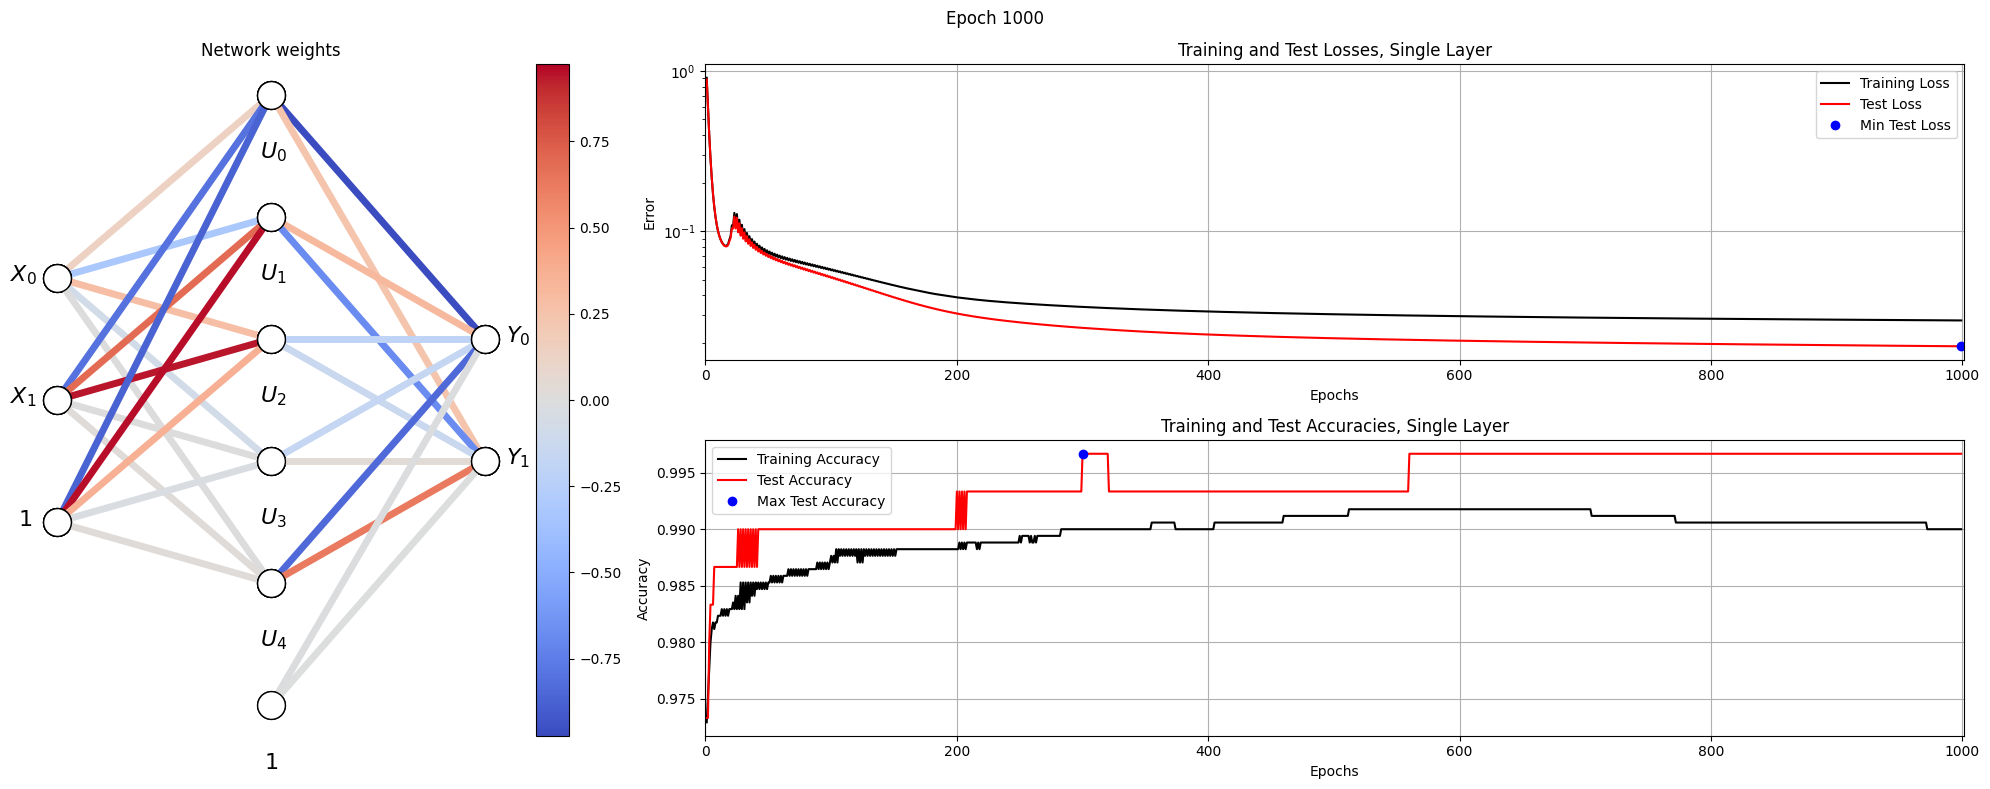

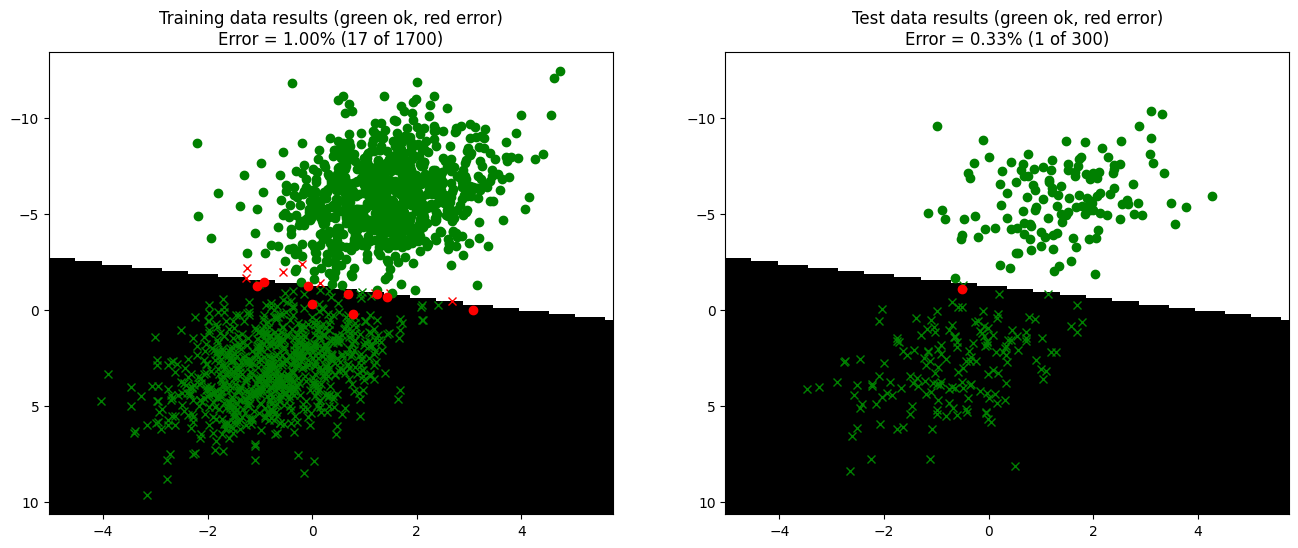

In [117]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 1
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, 0.15)

nClasses = np.unique(LTrain).shape[0]
nFeatures = XTrain.shape[1]

nHidden = 5

W1_0 = np.random.rand(nHidden, nFeatures).T * 2 - 1
B1_0 = np.random.rand(1, nHidden) * 0
W2_0 = np.random.rand(nClasses, nHidden).T * 2 - 1
B2_0 = np.random.rand(1, nClasses) * 0

params = {"epochs": 1000, "learningRate": 0.06, "normalize": False, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(datasetNr, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 2:</span>**

Optimize the training until you reach at least 98% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

#### **2.2 Optimizing dataset 2**

Train accuracy: 0.9988
Test accuracy: 1.0000
Test data confusion matrix:
[[148.   0.]
 [  0. 152.]]


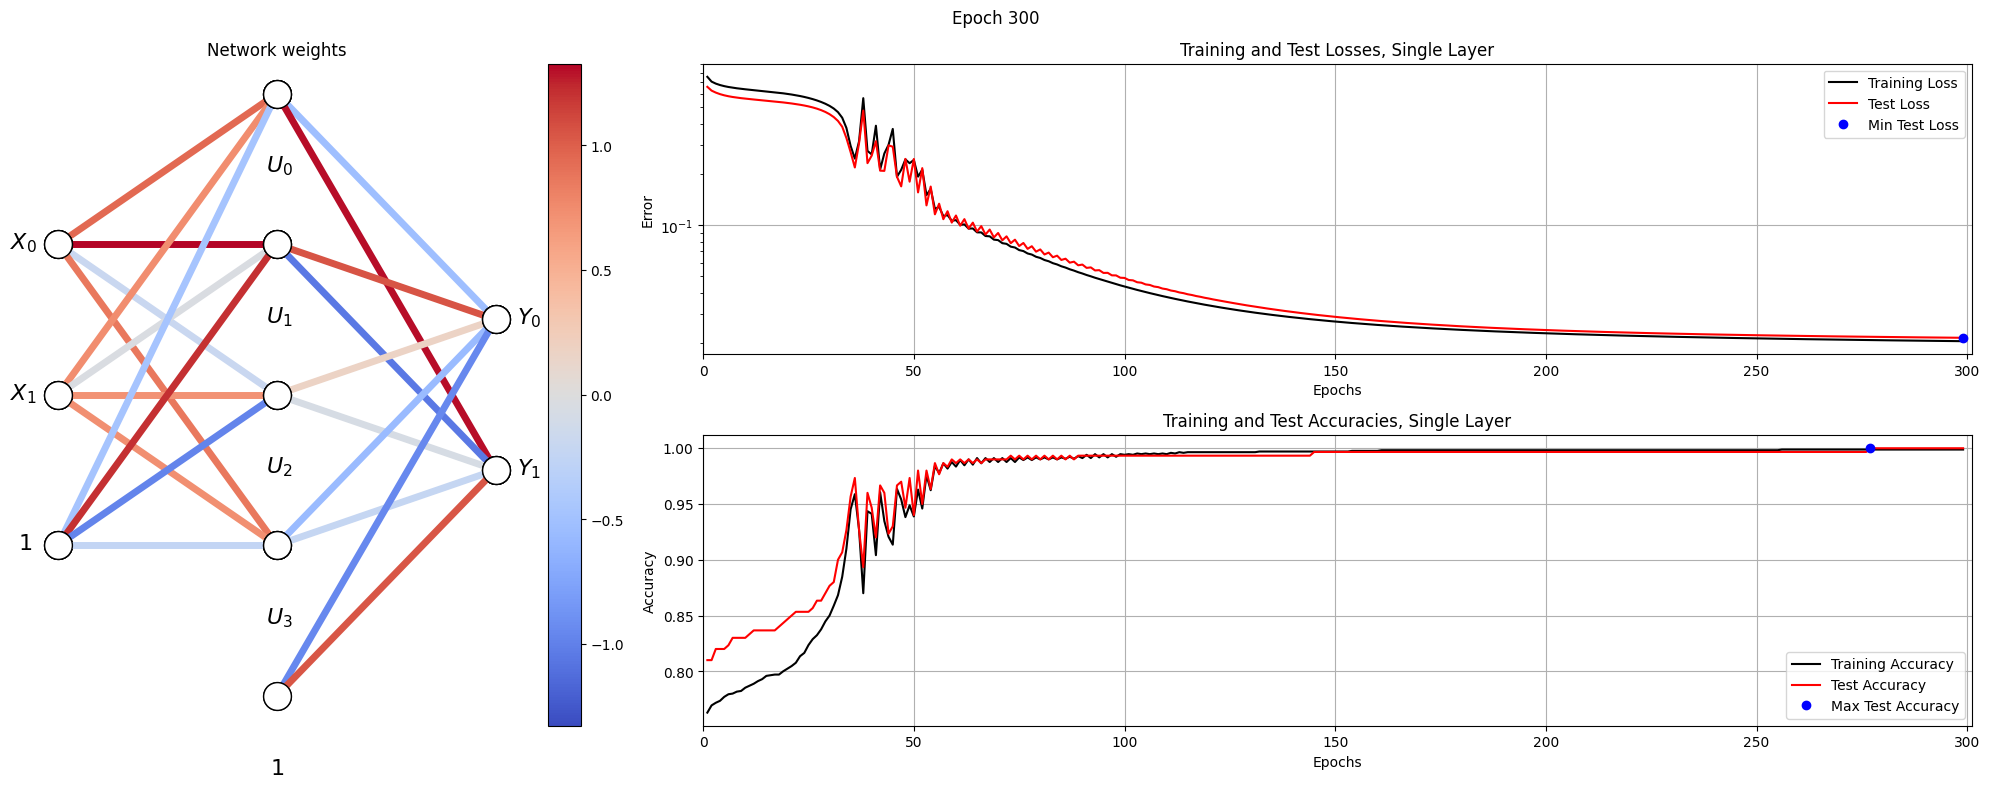

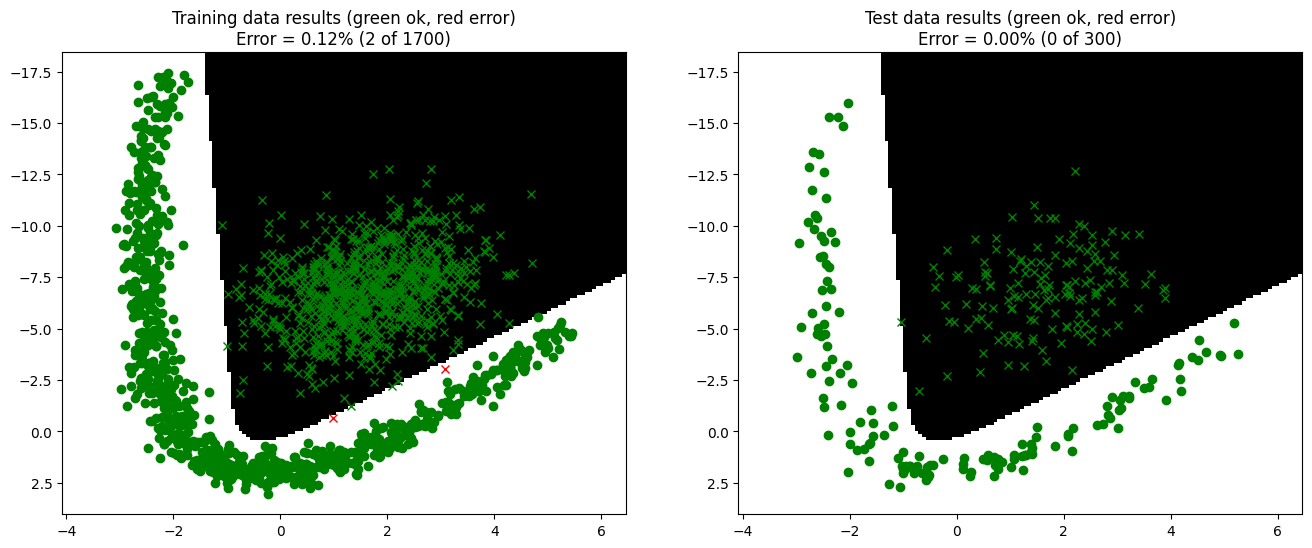

In [125]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 2
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, 0.15)

nClasses = np.unique(LTrain).shape[0]
nFeatures = XTrain.shape[1]

nHidden = 4

W1_0 = np.random.rand(nHidden, nFeatures).T * 2 - 1
B1_0 = np.random.rand(1, nHidden) * 0
W2_0 = np.random.rand(nClasses, nHidden).T * 2 - 1
B2_0 = np.random.rand(1, nClasses) * 0

params = {"epochs": 300, "learningRate": 0.20, "normalize": False, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(datasetNr, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 3:</span>**

Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

#### **2.3 Optimizing dataset 3**

Train accuracy: 0.9971
Test accuracy: 0.9967
Test data confusion matrix:
[[102.   0.   0.]
 [  0.  94.   0.]
 [  0.   1. 103.]]


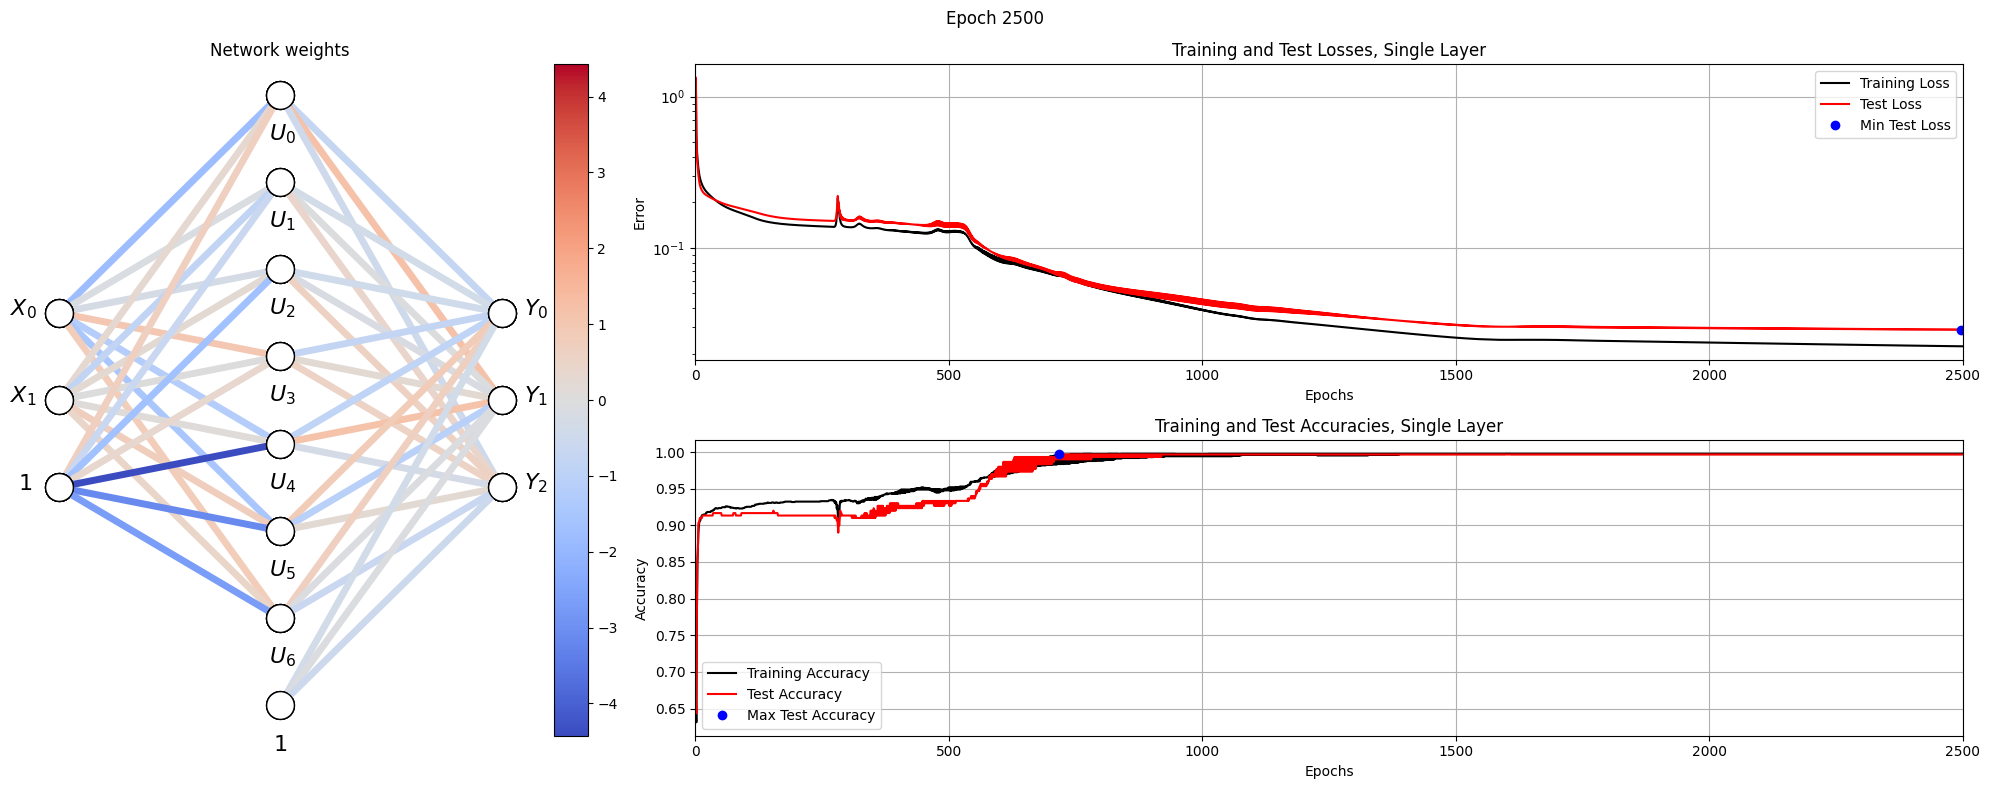

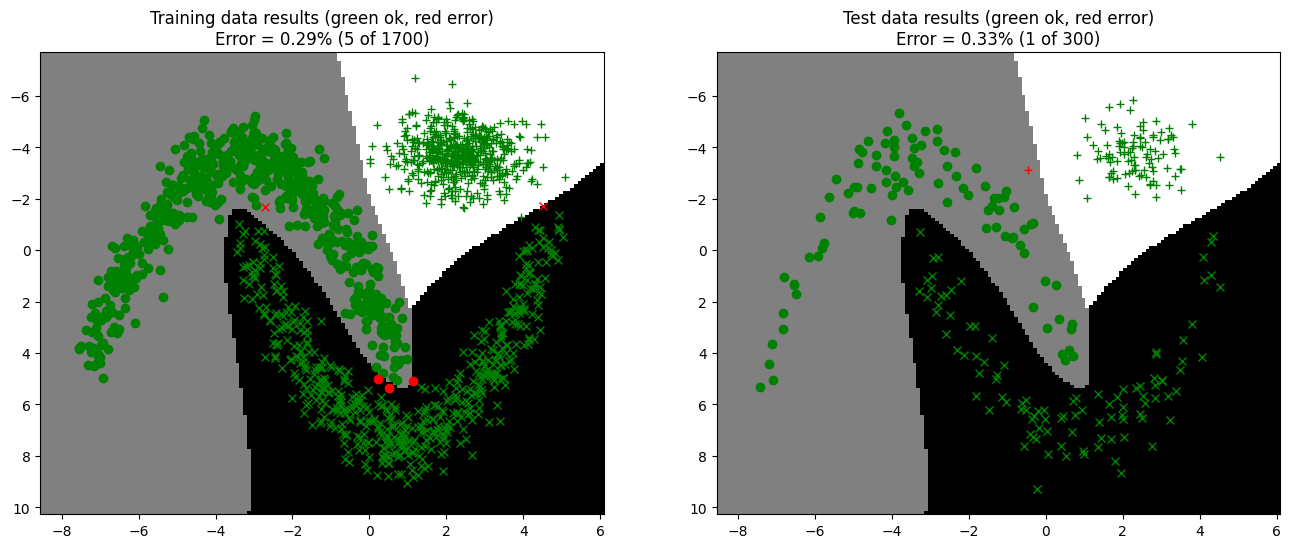

In [133]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 3
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, 0.15)

nClasses = np.unique(LTrain).shape[0]
nFeatures = XTrain.shape[1]

nHidden = 7

W1_0 = np.random.rand(nHidden, nFeatures).T * 2 - 1
B1_0 = np.random.rand(1, nHidden) * 0
W2_0 = np.random.rand(nClasses, nHidden).T * 2 - 1
B2_0 = np.random.rand(1, nClasses) * 0

params = {"epochs": 2500, "learningRate": 0.25, "normalize": False, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(datasetNr, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 4:</span>**

Optimize the training until you reach at least 99% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

#### **2.4 Optimizing dataset 4**

Train accuracy: 0.9736
Test accuracy: 0.9668
Test data confusion matrix:
[[72.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. 83.  2.  1.  0.  0.  0.  0.  2.  1.]
 [ 1.  0. 72.  2.  0.  1.  1.  0.  1.  0.]
 [ 0.  0.  1. 98.  0.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. 85.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0. 68.  0.  0.  1.  0.]
 [ 1.  1.  0.  0.  0.  0. 90.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0. 76.  0.  0.]
 [ 0.  1.  0.  0.  1.  0.  1.  0. 86.  1.]
 [ 0.  0.  0.  2.  0.  0.  0.  1.  0. 85.]]


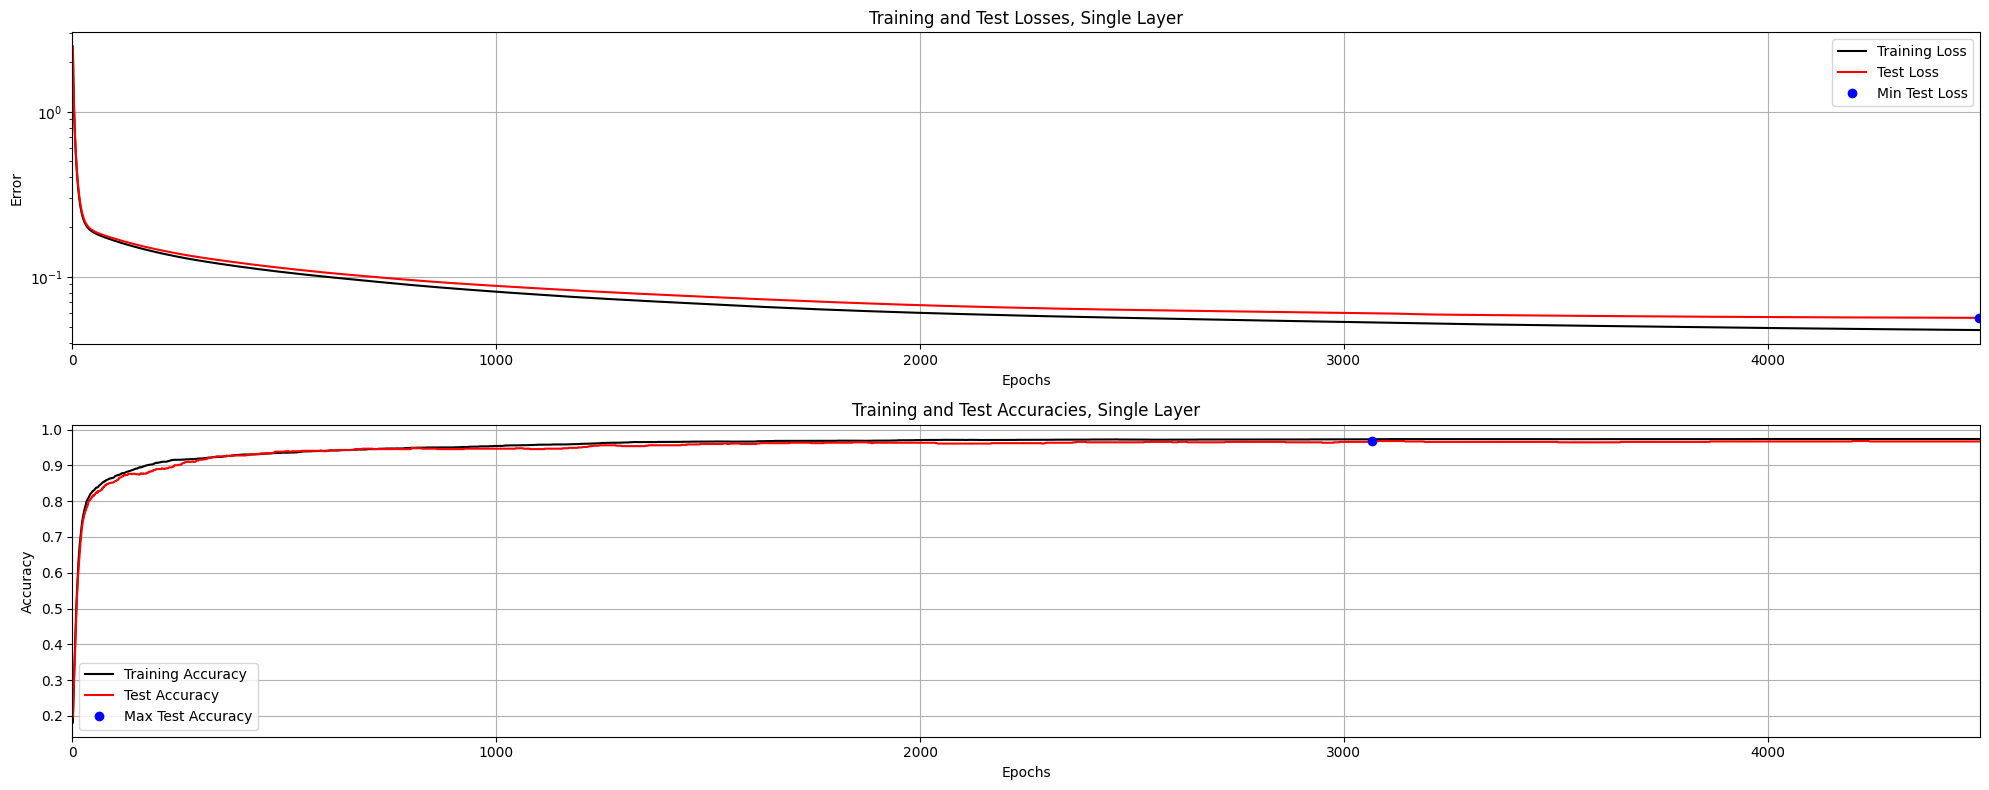

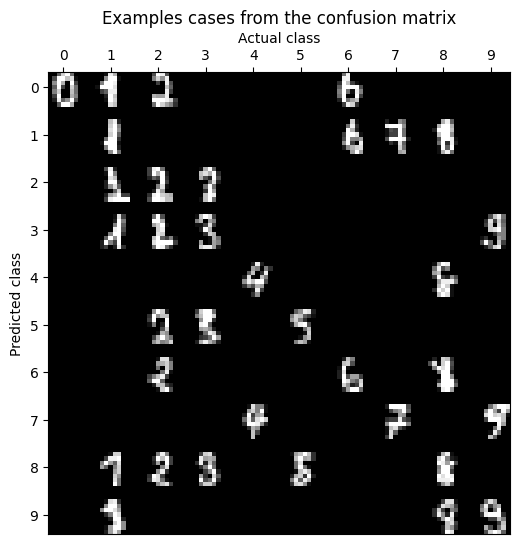

In [167]:
# --------------------------------------------
# === Your code here ========================= 
# --------------------------------------------
datasetNr = 4
X, D, L = loadDataset(datasetNr)

# Split data into training and test sets
XTrain, DTrain, LTrain, XTest, DTest, LTest = splitData(X, D, L, 0.15)

nClasses = np.unique(LTrain).shape[0]
nFeatures = XTrain.shape[1]

nHidden = 24

W1_0 = np.random.rand(nHidden, nFeatures).T * 2 - 1
B1_0 = np.random.rand(1, nHidden) * 0
W2_0 = np.random.rand(nClasses, nHidden).T * 2 - 1
B2_0 = np.random.rand(1, nClasses) * 0

params = {"epochs": 4500, "learningRate": 0.28, "normalize": True, "useTanhOutput": False}
# ============================================

trainMultiLayerOnDataset(datasetNr, 0.15, W1_0, B1_0, W2_0, B2_0, params)

#### **<span style="color:red">Question 5:</span>**

Optimize the training until you reach at least 96% test accuracy. Briefly motivate your choice of hyperparameters.

#### **<span style="color:green">Answer:</span>**

\[ Your answers here \]

---
### **3. Optional tasks**

Here are some optional tasks that you can try if you are interested to learn more.

#### **3.1 Tanh output activations**
Enable *tanh* activation in the output layer and re-train the networks in section 2. Do you see any differences in the convergence speed or the decision boundaries? It will probably be more interesting to use the `plotResultsDotsGradient` function for this experiment.

#### **3.2 Momentum gradient descent**
So far, you have used normal gradient descent without any modifications. This update rule often suffers from a slow convergence speed, and often gets stuck in local minima. There are many more advanced weight update algorithms that try to fix this problem. The most simple upgrade is to use a momentum term that remembers the previous gradients and uses both those and the new to update the weights. In particular, normal gradient descent is defined as

$$ \large W \leftarrow W - \alpha \nabla W $$

with learning rate $\alpha$. Momentum gradient descent is instead defined as

$$ \large G_t = \beta G_{t-1} + \alpha \nabla W $$

$$ \large W \leftarrow W - G_t $$

where $\beta$ is called the momentum term. A typical value of $\beta$ is 0.9, which means previous gradients decays exponetially with exponent 0.9. Intuitively, momentum can be though of in the physical sense, where a ball rolling down a hill retains momentum and therefore can get over small bumps in the hill, even if they temporarilly go upwards. The decay of old gradient can then be thought of as friction. Normal gradient descent has none of these physical intuitions, and will immediately get stuck if it encounters a local minima.

Your task is to rerun the training when using the momentum parameter. A good showcase of momentum should be dataset 4, which should converge much faster when using $\beta = 0.9$ compared to $\beta = 0$. If you want to go even further after this, you can take a look at [this](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6) blog post which neatly summarizes some of the most common update rules even more powerful than momentum.

#### **3.3 Hyperparameter search**

Manually optimizing the hyperparameters can get tedious, so why not do it automatically? If you have no problems with your computer becomming a heat radiator, an interesting experiment is to implement a grid search over some hyperparameters, for example learning rate, momentum, and size of the hidden layer, and see where the optimal combination is. You probably have to modify the `trainMultiLayerOnDataset` function in two ways to do this.
1. Return the metric you want to optimize, for example the final test loss.
2. Provide a `seed` input to the `splitData` function, to make sure the grid search always uses the same data for each combination of hyper parameters.